In [30]:
# import all
from torch import nn
import torch
import gymnasium as gym
from collections import deque 
import itertools 
import numpy as np
import random
import matplotlib.pyplot as plt 

In [31]:
# Values to be used 

gamma                   = 0.99   # discount rate 
batch_size              = 32
buffer_size             = 50000
replay_size             = 1000
epsilon_start           = 1.0
epsilon_end             = 0.02
epsilon_decay           = 10000
target_update_frequency = 1000
learning_rate           = 5e-4

In [32]:
# create environment 
env = gym.make("CartPole-v1")

In [33]:
replay_buffer = deque(maxlen = buffer_size)
reward_buffer = deque([0.0], maxlen = 100)

curr_reward   = 0.0

In [34]:
# Neural network class 
# nn.Sequential creates the required hidden layers in the order provided 

class Network(nn.Module):
    
    def __init__(self,env):
        super().__init__()
        
        input_features = int(np.prod(env.observation_space.shape))
        self.net = nn.Sequential( nn.Linear(input_features , 64) 
                                 , nn.Tanh() 
                                 , nn.Linear( 64 , env.action_space.n))
        
    def forward(self,x):
        return self.net(x)
    
    def act(self,curr_state):
        
        #convert the current state to a pytorch tensor 
        curr_state_t = torch.as_tensor(curr_state , dtype = torch.float32)
        q_values     = self(curr_state_t.unsqueeze(0))
        
        max_q        = torch.argmax(q_values , dim=1)[0]
        action       = max_q.detach().item()
        
        return action 
    
                                

In [35]:
# create networks 

online_network = Network(env)
target_network = Network(env)

# copy one network to another 
# load_state_dict is used to copy one model parameters to another 

target_network.load_state_dict(online_network.state_dict())

optimizer = torch.optim.Adam(online_network.parameters() , lr=learning_rate)

In [36]:
# Initialize the replay buffer 

curr_state , info = env.reset()

for _ in range(replay_size):
    
    # take a random action
    action = env.action_space.sample()
    new_state , reward , terminated , truncated, info = env.step(action)
    
    # collect the experiences
    experience_tuple = (curr_state , action , reward , terminated ,truncated, new_state)
    replay_buffer.append(experience_tuple)
    
    curr_state = new_state 
    
    if terminated or truncated :
        curr_state , info = env.reset()
    

In [37]:
# Training the agent 

curr_state , info = env.reset()
episode_n = 0
episodic_rewards = []

for i in itertools.count():
    
    # Epsilon Greedy Strategy to explore 
    epsilon = np.interp( i , [0,epsilon_decay] ,[ epsilon_start,epsilon_end ] )
    random_value = random.random()
    
    if random_value <= epsilon:
        action = env.action_space.sample()
    else :
        action = online_network.act(curr_state)
    
    new_state , reward , terminated , truncated , info = env.step(action)
    
    # collect the experiences
    experience_tuple = (curr_state , action , reward , terminated , truncated , new_state)
    replay_buffer.append(experience_tuple)
    
    curr_state = new_state 
    curr_reward += reward 
    
    if terminated or truncated :
        curr_state , info = env.reset()
        
        reward_buffer.append(curr_reward)
        curr_reward = 0.0
        
        episode_n +=1 
        episodic_rewards.append(np.mean(reward_buffer))
        
        
    # For rendering the code , beware of decommenting as your kernel can crash
#     if len(reward_buffer) >=100:
#         if np.mean(reward_buffer)>=200:
#             while True :
#                 action = online_network.act(curr_state)
                
#                 curr_state , reward , terminated , truncated , info = env.step(action)
#                 env.render()
                
#                 if terminated or truncated:
#                     env.reset
    
    
    # Extract parameters for Gradient Descent 
    experiences  = random.sample( replay_buffer , batch_size )
    
    
    curr_states  = np.asarray([e[0] for e in experiences])
    actions      = np.asarray([e[1] for e in experiences])
    rewards      = np.asarray([e[2] for e in experiences])
    terminated_s = np.asarray([e[3] for e in experiences])
    truncated_s  = np.asarray([e[4] for e in experiences])
    new_states   = np.asarray([e[5] for e in experiences])

    
    curr_states_t   = torch.as_tensor(curr_states, dtype=torch.float32)
    actions_t       = torch.as_tensor(actions,dtype=torch.int64).unsqueeze(-1)
    rewards_t       = torch.as_tensor(rewards,dtype=torch.float32).unsqueeze(-1)
    terminated_s_t  = torch.as_tensor(terminated_s,dtype=torch.float32).unsqueeze(-1)
    truncated_s_t   = torch.as_tensor(truncated_s,dtype=torch.float32).unsqueeze(-1)
    new_states_t    = torch.as_tensor(new_states,dtype=torch.float32)
    
    # Compute Targets 
    target_q_values      = target_network(new_states_t)
    max_target_q_values  = target_q_values.max(dim=1, keepdim=True)[0]
    
    
    temp = torch.logical_or(terminated_s_t,truncated_s_t)
    targets = rewards_t + gamma * (torch.logical_not(temp)) * max_target_q_values
    
    # Compute TD errors
    q_values        = online_network(curr_states_t)
    action_q_values = torch.gather(input=q_values , dim=1 , index=actions_t)
    
    error = nn.functional.smooth_l1_loss(action_q_values , targets)  # Huber loss
    
    # Gradient Descent 
    optimizer.zero_grad()
    error.backward()
    optimizer.step()
    
    # Update Target network 
    if i%target_update_frequency==0:
        target_network.load_state_dict(online_network.state_dict())
        
#     # Logging 
#     if i%1000==0:
#         print()
#         print("Steps" , i)
#         print("Average Reward" , np.mean(reward_buffer))
        
#     if i==10000:
#         break

    if episode_n == 500:
        break
    

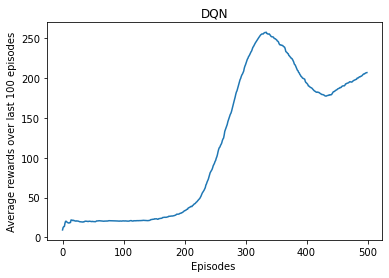

In [41]:
# We have episodic rewards with us 
#print(episodic_rewards)
# Plotting function 
plt.plot(episodic_rewards)

plt.xlabel('Episodes ')
plt.ylabel(' Average rewards over last 100 episodes ')
plt.title('DQN')

plt.show()